# Exploratory Data Analysis
## Group SHINOBI: HONG-KOH-NOUV

This python notebook contents the information of the data analysis to help provide possible decisions for the next part such as modeling and applying feature engineering. We explored the given dataset of **scMARK** to understand its nature. 

In [14]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

# Feature Engineering
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Model Building
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Evaluation
from sklearn.metrics import balanced_accuracy_score
from problem import BalancedAccuracy
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [2]:
from problem import get_train_data, get_test_data
X_train, y_train = get_train_data()
X_test, y_test = get_test_data()

In [3]:
X_train.shape

(1000, 13551)

In [10]:
X_train[:10].toarray()

array([[1., 0., 0., ..., 3., 2., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 2., 0., 0.]], dtype=float32)

In [5]:
y_train.shape

(1000,)

In [12]:
y_train[:10]

['T_cells_CD4+', 'T_cells_CD4+', 'T_cells_CD4+', 'T_cells_CD4+', 'T_cells_CD8+', 'T_cells_CD4+', 'Cancer_cells', 'Cancer_cells', 'NK_cells', 'T_cells_CD8+']
Categories (4, object): ['Cancer_cells', 'NK_cells', 'T_cells_CD4+', 'T_cells_CD8+']

### Class distribution

([0, 1, 2, 3],
 [Text(0, 0, 'Cancer_cells'),
  Text(1, 0, 'NK_cells'),
  Text(2, 0, 'T_cells_CD4+'),
  Text(3, 0, 'T_cells_CD8+')])

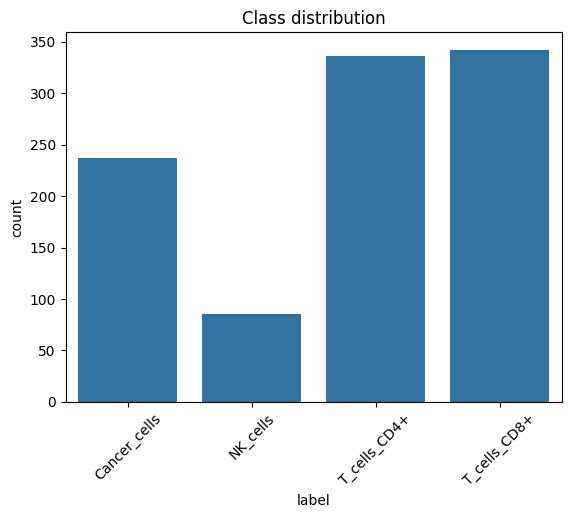

In [15]:
df_labels = pd.DataFrame({'label': y_train})
sns.countplot(data=df_labels, x='label')
plt.title("Class distribution")
plt.xticks(rotation=45)

This dataset seems to be unbalanced. The proportion of **NK_cells** is lower than other cells. This could mean we may get a good result on training dataset but not on tesing dataset. 

To improve, we have some ideas like using Oversampling the Minority Class (Random Oversampling or Synthetic Minority Over-sampling Technique) or using other technique depend on the performance or the adjustment (Still need a discussion after testing).

### Sparsity analysis

Because single-cell RNA-seq data is extremely sparse:
most values are zero.

Why? From what we see above:
- A cell expresses only some genes, not all 14,000
- Most genes are off in most cells
- So the matrix is full of zeros

For each cell, we compute percentage of genes that have expression equal to 0.

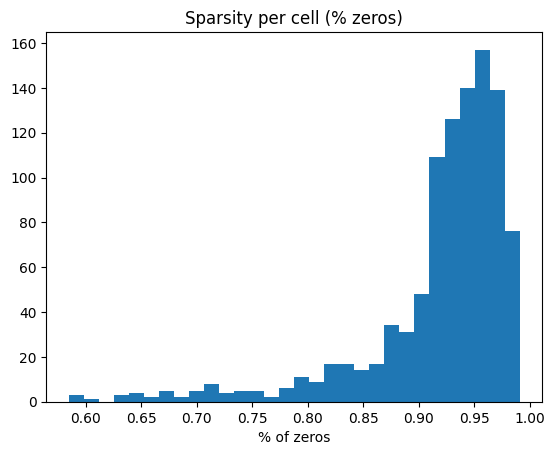

In [16]:
X_dense = X_train.toarray()

cell_zero_pct = (X_dense == 0).mean(axis=1)

plt.hist(cell_zero_pct, bins=30)
plt.title("Sparsity per cell (% zeros)")
plt.xlabel("% of zeros");

Most cells have 90–98 percent zeros. It means that:
- Each cell only expresses 2–10 percent of genes.
- This is normal, expected for scRNA-seq.[Macosko et al., 2018](https://www.nature.com/articles/s41467-017-02554-5)
- It also confirms that raw data is ultra sparse.

This also could mean:
- Sparse data = harder for models
- Many zeros = noise
- We need dimensionality reduction (PCA, HVG)
- We need normalization

For each gene, we compute percentage of cells where this gene is 0.

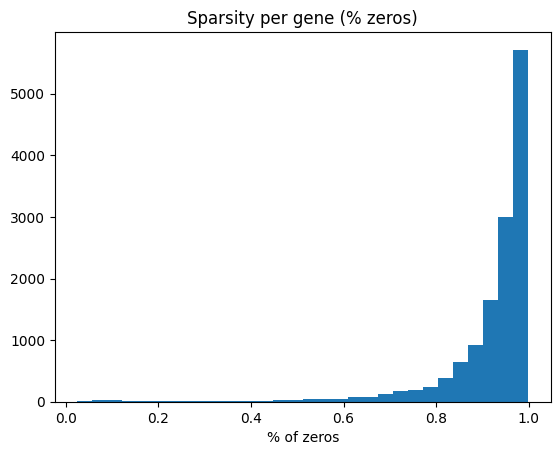

In [17]:
gene_zero_pct = (X_dense == 0).mean(axis=0)

plt.hist(gene_zero_pct, bins=30)
plt.title("Sparsity per gene (% zeros)")
plt.xlabel("% of zeros");

The majority of genes have 95–100 percent zeros which means:
- Most genes are expressed in almost no cells
- These genes carry little useful information for classification

Most genes do not vary enough; we should remove low-variance genes.

This is why scRNA workflows always include:
- Selecting Highly Variable Genes (HVG)
- Removing low-information genes
- Reducing the dimension from 14,000 → 2,000 or 500

### Gene variance analysis

We compute the variance of each gene across all 1000 cells. The goal is to identify how much each gene changes from one cell to another.

This step helps us understand which genes are informative (high variance) and which genes are mostly constant or inactive (low variance).

Variance is a key metric for deciding whether we should keep or filter out a gene in downstream modeling:
- Genes with very low variance carry little useful information for classification because they barely change between cell types.
- Genes with high variance are typically more biologically meaningful and help distinguish different cell types.
- Identifying the variance distribution allows me to decide how many Highly Variable Genes (HVG) to keep.
- This analysis also reveals whether dimensionality reduction is necessary (it usually is).

Text(0, 0.5, 'Number of genes')

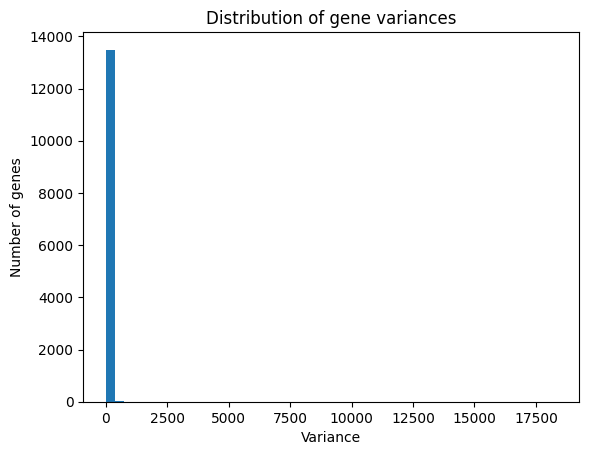

In [18]:
gene_variances = X_dense.var(axis=0)

plt.hist(gene_variances, bins=50)
plt.title("Distribution of gene variances")
plt.xlabel("Variance")
plt.ylabel("Number of genes")

The distribution is extremely skewed: almost all genes have very low variance, while a small group shows very high variance.

This pattern is typical for single-cell RNA-seq data, where most genes are expressed at low or near-constant levels.

In [19]:
(gene_variances < 1e-5).mean()

0.0

The near-zero result for (gene_variances < 1e-5).mean() simply means the threshold is too strict, not that variance is high.

The important takeaway is that only a small subset of genes carries meaningful signal. For this case, after researching method on internet it is shown that selecting the most variable genes (HVGs) or applying dimensionality reduction (PCA) is strongly recommended before any classifier. (Discussion needed)

### Total expression per cell

Here, I compute the total gene expression per cell by summing all gene counts for each of the 1000 cells.

This step allows us to examine how much overall expression each cell has, which is important for understanding cell quality and expression variability before applying machine learning models.

Why?
- To detect low-quality cells with unusually low total expression (possible damaged or empty droplets).
- To spot high-expression outliers (possible doublets or highly active cells).
- To check whether total expression varies a lot across cells, which tells me whether normalization is required.
- This is a standard quality-control step in single-cell data preprocessing.

Text(0, 0.5, 'Number of cells')

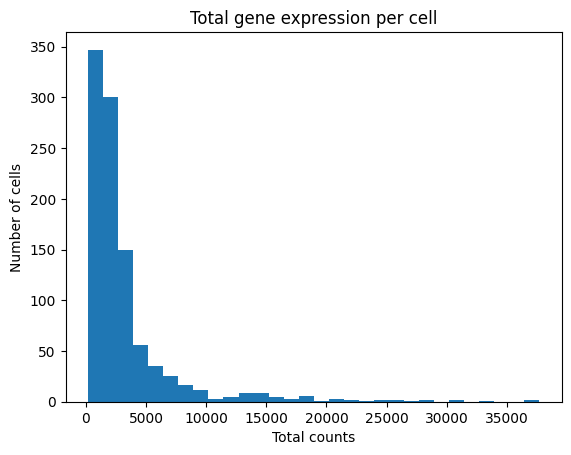

In [20]:
total_counts = X_dense.sum(axis=1)

plt.hist(total_counts, bins=30)
plt.title("Total gene expression per cell")
plt.xlabel("Total counts")
plt.ylabel("Number of cells")

The distribution is strongly right-skewed: most cells have 500–3000 total counts.

A minority of cells have very high totals (up to ~35,000), forming a long tail.

There are no extreme low-count cells, so no immediate signs of major quality issues.

Because total counts vary widely across cells, normalization will be necessary before running PCA or training a classifier.

### PCA for separability visualization

I apply PCA on the normalized gene expression matrix to project the 13,551-dimensional data into 2 dimensions.

This allows us to visualize the dataset and see whether different cell types show natural separation in a lower-dimensional space.

Each point represents a cell, and colors correspond to the four cell-type labels.

Why?(To understand more):
- To check whether the four cell types exhibit distinct global expression patterns.
- To evaluate whether the dataset is roughly separable before training machine learning models
- PCA helps reveal whether dimensionality reduction (PCA, HVG selection) will be helpful for classification.
- This step also helps identify potential outliers or cells with unusual expression profiles.

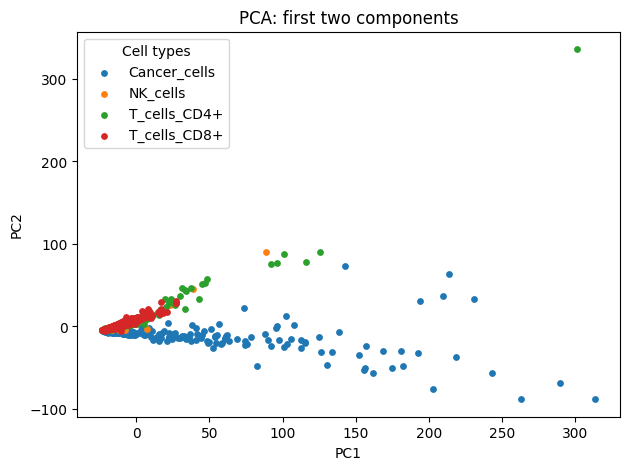

In [23]:
scaler = StandardScaler(with_mean=True, with_std=True)
X_scaled = scaler.fit_transform(X_dense)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

labels = y_train.categories
codes = y_train.codes

plt.figure(figsize=(7,5))
for i, label in enumerate(labels):
    idx = np.where(codes == i)
    plt.scatter(X_pca[idx, 0], X_pca[idx, 1], s=15, label=label)

plt.title("PCA: first two components")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="Cell types")
plt.show()

The PCA plot shows partial separation between cell types:
- Cancer_cells form a broad cluster with high spread along PC1.
- NK_cells appear in a compact region, slightly shifted from Cancer_cells.
- T_cells_CD4+ and T_cells_CD8+ occupy similar spaces but still show some separation.

The large spread of Cancer_cells along PC1 suggests high variability within that class.

The overlap between CD4+ and CD8+ T-cells reflects their biological similarity, which may make classification harder.

Overall, PCA reveals meaningful structure, confirming that gene expression patterns contain enough signal for supervised learning.

### PCA explained variance

Text(0, 0.5, 'Variance ratio')

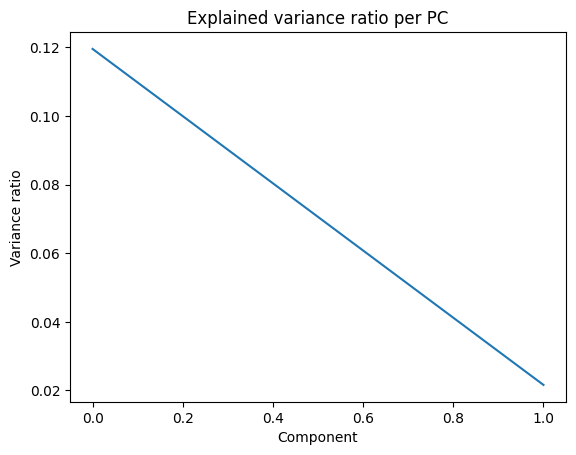

In [24]:
plt.plot(pca.explained_variance_ratio_)
plt.title("Explained variance ratio per PC")
plt.xlabel("Component")
plt.ylabel("Variance ratio")

### UMAP

Text(0.5, 1.0, 'UMAP embedding')

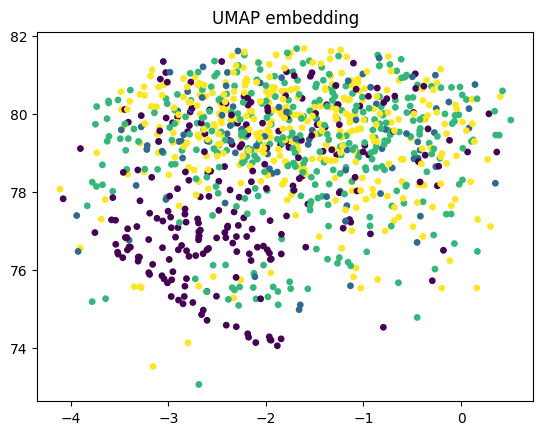

In [26]:
from umap import UMAP

umap = UMAP(n_neighbors=15, min_dist=0.2)
X_umap = umap.fit_transform(X_scaled)

plt.scatter(X_umap[:,0], X_umap[:,1], c=y_train.codes, s=15)
plt.title("UMAP embedding")

### Correlation structure between genes

Then, I compute the pairwise correlation matrix between the most variable genes (top HVGs) and visualize this matrix as a hierarchically clustered heatmap, which groups genes with similar expression patterns.

It shows how genes co-vary across cells and whether there are clear gene modules or clusters.

How and why?
- To detect groups of genes that behave similarly across cells (co-expression modules).
- To check whether the dataset contains structured patterns instead of random noise.
- To identify redundant genes, which supports the need for dimensionality reduction.
- To see if certain sets of genes form distinct blocks that may correspond to specific cell types.
- This step guides feature selection and motivates methods like PCA or selecting highly correlated gene clusters.

h:\scmark-classification-data-shinobi\venv\Lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
h:\scmark-classification-data-shinobi\venv\Lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


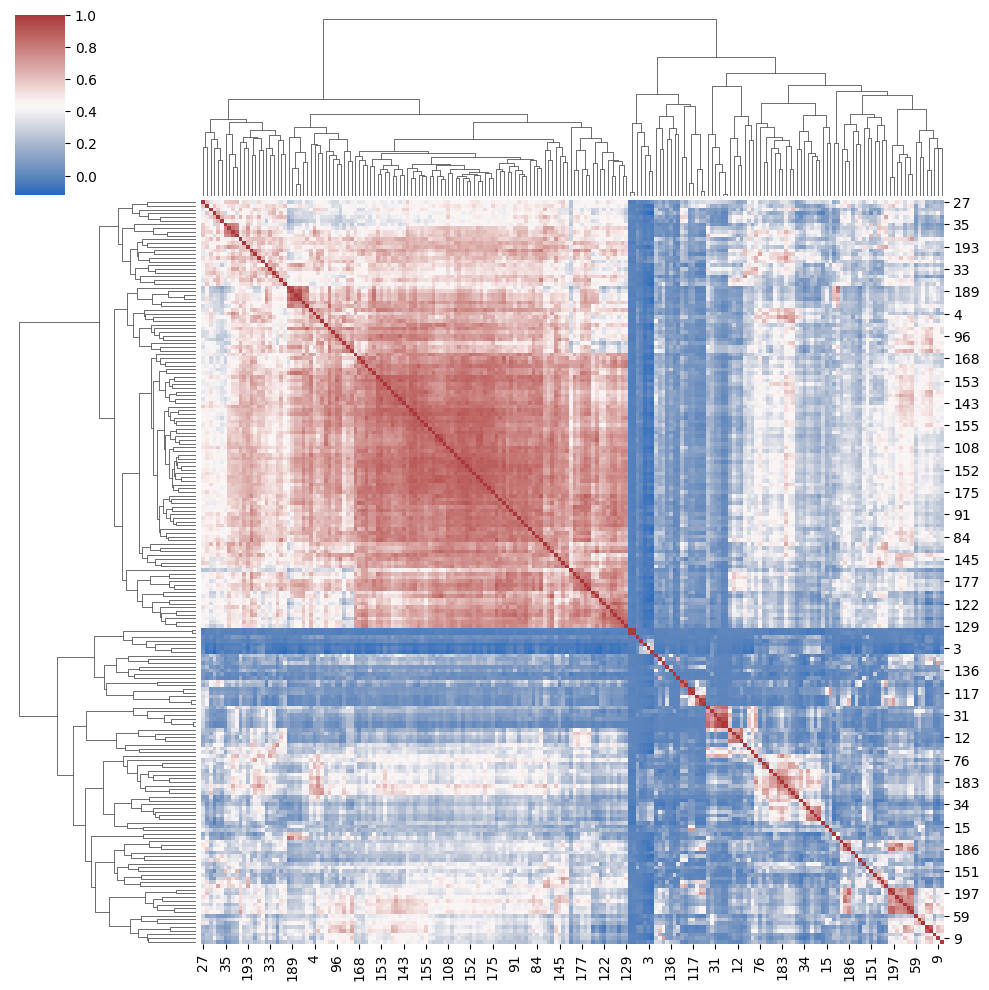

In [27]:
idx = np.argsort(gene_variances)[-200:]
X_top200 = X_dense[:, idx]

corr = np.corrcoef(X_top200.T)
sns.clustermap(corr, cmap="vlag", figsize=(10,10))

The heatmap shows clear block structures:
- A large red block of highly correlated genes, indicating a strong co-expression module.
- A blue region of anti-correlation, where genes behave in opposite directions.

The dendrograms group genes into distinct clusters, meaning the dataset contains strong correlation patterns rather than random noise.

These correlated blocks may correspond to biological pathways or cell-type–specific marker groups.

The presence of strong correlation confirms that many genes are redundant, reinforcing the need for PCA or feature selection before classification.

## What we need to discuss for next step

1. **Normalize the data** to correct for differences in total gene counts between cells (e.g., log-normalization or standard scaling).
2. **Select informative genes** by keeping only the Highly Variable Genes (HVG) (e.g., top 500–2000 most variable genes).
3. **Reduce dimensionality** using PCA (or PCA + UMAP) before classification to remove noise and handle sparsity.
4. **Handle class imbalance** using class weights or oversampling if needed (minority class = NK_cells).
5. **Remove or check outliers** (cells with extremely high expression totals if they affect performance).
6. **Prepare final feature matrix** using the chosen preprocessing steps (normalization -> HVG -> PCA).
7. **Build and test** baseline models inside the RAMP framework (e.g., logistic regression, linear SVM, random forest).
8. **Compare model performance** and adjust preprocessing choices accordingly (e.g., number of HVGs, number of PCA components).